# This notebook is designed to try and create heat maps for h-abstraction reactions on biofules

In [1]:
from rmgpy.molecule import Molecule, Bond, Atom
from rmgpy.reaction import Reaction
from rmgpy.kinetics import Arrhenius, MultiArrhenius

import rdkit
import inspect
from rmgpy.qm.molecule import QMMolecule, Geometry
from rmgpy.qm.main import QMSettings
import os
import re
from collections import defaultdict, OrderedDict
import pandas as pd
import itertools

%matplotlib inline

import matplotlib
import numpy as np
import sympy
import matplotlib.pyplot as plt
from matplotlib.collections import EllipseCollection 


## This next portion of the code is deisgned to loop through all of the log files for bioTST and create a dataframe with the parent molecule, the abstractor, the radical of the parent molecule, the arrhenius expression and the reaction.

In [2]:
# Getting Kinetics and Reactions from log file
scratch_directory = "/gss_gpfs_scratch/harms.n/bioTST/biofuels_rerun"
results = defaultdict(OrderedDict)

j = 0 
k=0
for file in os.listdir(scratch_directory):
    if file.endswith(".log") and file.startswith("AutoTST"):
        m  =  re.match("AutoTST-biofuels.(.*).combined.log", file)
        if not m:
            print file
        i = int(m.group(1))
        r = results[i]
        r["Log Number"] = i
        #print i
        
        
        file_name = os.path.join(scratch_directory, file)
        with open(file_name, "r") as f:
            lines = f.readlines()
            for line in lines:
                m = re.match('biofuelsTST.py:191 performCalcs INFO chemkinRxn: (.*)', line)
                if m:
                    rxn = eval(m.group(1))
                    #print rxn
                    r['Reaction'] = rxn 
                    
                    # The following portion of the code creates the pair of molecules which have the greatest weight
                    # This _should_ be the biofule of interest and its corresponding radical.
                    
                    weight0, weight1 = pd.DataFrame(rxn.pairs).applymap(Molecule.getMolecularWeight).sum(axis=1)
                    if weight0 > weight1:
                        heavy_pair = rxn.pairs[0]
                        light_pair = rxn.pairs[1]
                    else:
                        heavy_pair = rxn.pairs[1]
                        light_pair = rxn.pairs[0]
                    
                    #print heavy_pair
                    #print light_pair
                    
                    light0, light1 = light_pair
                    
                    
                    heavy0, heavy1 = heavy_pair
                
                    if heavy0.isRadical():
                        r["Radical Molecule"] = heavy0.toSMILES()
                        r["Parent Molecule"] = heavy1.toSMILES()
                        abstractor = light_pair[1]
                        r["Abstractor"] = abstractor.toSMILES()
                    else:
                        r["Radical Molecule"] = heavy1.toSMILES()
                        r["Parent Molecule"] = heavy0.toSMILES()
                        abstractor = light_pair[0]
                        r["Abstractor"] = abstractor.toSMILES()
                        
                    #print abstractor
                    
            
                if 'We have calculated kinetics' in line:
                    kinetics = eval(line.split("We have calculated kinetics ")[-1])
                    r["Arrhenius Expression"] = kinetics
                    r["Has Kinetics"] = 1
                    #print kinetics
                    j += 1
                if "Boo" in line:
                    r["Has Kinetics"] = 0 
                    k += 1

        del m
        #print
        #print
df = pd.DataFrame(results).T
df = df.set_index(df["Parent Molecule"])
print "The overall success rate is {0}% with {1} successes and {2} failures".format(float(j)/(j+k) *100 , j, k)
df

The overall success rate is 54.0268456376% with 161 successes and 137 failures


,Abstractor,Arrhenius Expression,Has Kinetics,Log Number,Parent Molecule,Radical Molecule,Reaction
Parent Molecule,,,,,,,
OO,[O],NaN,0,1,OO,[O]O,"<Molecule ""[O]""> + <Molecule ""OO""> <=> <Molecu..."
OO,[O][O],NaN,0,2,OO,[O]O,"<Molecule ""[O]O""> + <Molecule ""[O]O""> <=> <Mol..."
[O]O,[OH],NaN,0,3,[O]O,[O][O],"<Molecule ""[O][O]""> + <Molecule ""O""> <=> <Mole..."
[O]O,[H],NaN,0,4,[O]O,[O][O],"<Molecule ""[O][O]""> + <Molecule ""[H][H]""> <=> ..."
[O][O],[OH],NaN,0,5,[O][O],[O]O,"<Molecule ""[O]O""> + <Molecule ""[O]""> <=> <Mole..."
[O]O,[CH3],NaN,0,6,[O]O,[O][O],"<Molecule ""[O][O]""> + <Molecule ""C""> <=> <Mole..."
OO,[CH2],"Arrhenius(A=(0.997252,'cm^3/(mol*s)'), n=3.716...",1,7,OO,[O]O,"<Molecule ""OO""> + <Molecule ""[CH2]""> <=> <Mole..."
CC(C)CC(C)(C)C,[O]O,NaN,0,8,CC(C)CC(C)(C)C,C[C](C)CC(C)(C)C,"<Molecule ""[O]O""> + <Molecule ""CC(C)CC(C)(C)C""..."
CC(C)CC(C)(C)C,[O]O,"Arrhenius(A=(1.44774e-06,'cm^3/(mol*s)'), n=4....",1,9,CC(C)CC(C)(C)C,CC(C)[CH]C(C)(C)C,"<Molecule ""OO""> + <Molecule ""CC(C)[CH]C(C)(C)C..."


In [3]:
a = np.unique(df[(df["Has Kinetics"] == 1) | (df["Has Kinetics"] == 0)].index.values)

list_of_abstractors = [
    "[O]",
    "[CH3]",
    "[O]O",
    "[H]",
    "[OH]",
    "[O][O]"    
]

list_of_parents = [x for x in a if x not in list_of_abstractors]

# Removing non biofuel parents
for parent in list_of_parents:
    if len(parent) < 5:
        list_of_parents.remove(parent)

list_of_parents

['C=CC(C)=CCCC(=C)C',
 'C=CCCCC(C)C',
 'CC(=O)C(C)CC(C)C',
 'CC(=O)OCCC(C)C',
 'CC(C)(C)OCC(CO)OC(C)(C)C',
 'CC(C)CC(=O)CC(C)C',
 'CC(C)CC(C)(C)C',
 'CC1=CCC2CC1C2(C)C',
 'CC1=CCCC1=O',
 'CC1C=CC(C)=CC=1',
 'CC1CCCC1',
 'CC=CCCC(C)C',
 'CCC(C)(C)O',
 'CCC(C)CC(C)C',
 'CCC(CC)OC(C)C',
 'CCC=CCC(C)C',
 'CCCC(C)C=C(C)C',
 'CCCC(C)CO',
 'CCCC=CC(C)C',
 'CCCCC(C)CC',
 'CCCCC=C(C)C',
 'CCCCCC1CCC(C)O1',
 'CCOC(=O)C(C)C',
 'OO']

In [4]:
d = {}
dd = {}

pp = pd.DataFrame()
p = pd.DataFrame()

for abstractor in list_of_abstractors:
    for parent in list_of_parents:
        reesults = df[(df["Abstractor"] == abstractor) & (df["Parent Molecule"] == parent) & (df["Has Kinetics"].notnull())]
        
        #d[parent] = {abstractor:dict(zip(reesults["Radical Molecule"].values, reesults["Has Kinetics"].values))}
        
        #dict(zip(reesults["Radical Molecule"].values, reesults["Has Kinetics"].values))
        d[parent] = {abstractor:np.sum(np.array(reesults["Has Kinetics"].values))}
        dd[parent] = {abstractor:len((np.array(reesults["Has Kinetics"].values)))}
        
        
    
    if pp.empty:
        pp = pd.DataFrame(d)
        p = pd.DataFrame(dd)
    else:
        pp = pp.append(pd.DataFrame(d))
        p = p.append(pd.DataFrame(dd))

(pp.sum(axis=1) / p.sum(axis=1)).sort_values(), pp.sum(axis=1), p.sum(axis=1)

([O][O]    0.000000
 [O]       0.037037
 [O]O      0.451327
 [OH]      0.533333
 [CH3]     0.705882
 [H]       0.900000
 dtype: float64, [O]        1
 [CH3]     36
 [O]O      51
 [H]       45
 [OH]      24
 [O][O]     0
 dtype: int64, [O]        27
 [CH3]      51
 [O]O      113
 [H]        50
 [OH]       45
 [O][O]      1
 dtype: int64)

In [5]:
(pp.sum(axis=0) / p.sum(axis=0)).sort_values()

CC(C)(C)OCC(CO)OC(C)(C)C    0.000000
CC1=CCC2CC1C2(C)C           0.000000
CCC(CC)OC(C)C               0.100000
OO                          0.200000
CC(=O)OCCC(C)C              0.300000
CCCC(C)C=C(C)C              0.333333
CC(=O)C(C)CC(C)C            0.363636
C=CC(C)=CCCC(=C)C           0.411765
CCC=CCC(C)C                 0.416667
CC1C=CC(C)=CC=1             0.444444
CCOC(=O)C(C)C               0.444444
CC(C)CC(=O)CC(C)C           0.444444
CCCC=CC(C)C                 0.538462
CC(C)CC(C)(C)C              0.555556
CCCCC=C(C)C                 0.600000
CC=CCCC(C)C                 0.615385
CC1=CCCC1=O                 0.666667
C=CCCCC(C)C                 0.687500
CCCCCC1CCC(C)O1             0.708333
CCCCC(C)CC                  0.714286
CCCC(C)CO                   0.722222
CCC(C)CC(C)C                0.736842
CC1CCCC1                    0.800000
CCC(C)(C)O                  0.800000
dtype: float64

### This is a test for a single molecule and a single abstractor

0 1 SINGLE
1 2 SINGLE
2 3 SINGLE
3 4 DOUBLE
3 5 SINGLE
5 6 SINGLE
5 7 SINGLE
1 <type 'int'>
True
Has kinetics Arrhenius(A=(1.16539,'cm^3/(mol*s)'), n=3.03681, Ea=(57.4744,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.23309, dn = +|- 0.0274982, dEa = +|- 0.151268 kJ/mol""")
nan <type 'float'>
False
0 <type 'int'>
False
failed
nan <type 'float'>
False
nan <type 'float'>
False


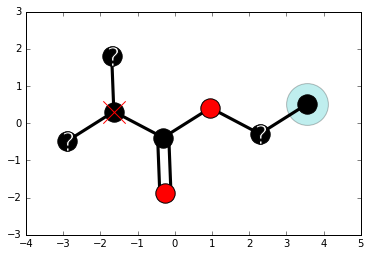

In [6]:
#Using this for a single molecule

parent = "CCOC(=O)C(C)C"
abstractor = "[OH]"

parent_rdmol = rdkit.Chem.AllChem.MolFromSmiles(parent)
parent_rdmol.Compute2DCoords()
tup = parent_rdmol.GetConformers()
rdconformer = tup[0]
fig, ax = plt.subplots(figsize=(6,6), dpi=120)
# Plotting the atoms of the molecule
for atom in parent_rdmol.GetAtoms():
    atom_index = atom.GetIdx()
    
    
    
    
    if atom.GetAtomicNum() == 6:
        plt.scatter(rdconformer.GetAtomPosition(atom_index).x, rdconformer.GetAtomPosition(atom_index).y, c="k", alpha=1, zorder=0)
    elif atom.GetAtomicNum() == 7:
        plt.scatter(rdconformer.GetAtomPosition(atom_index).x, rdconformer.GetAtomPosition(atom_index).y, c="b", alpha=1, zorder=0)
    elif atom.GetAtomicNum() == 8:
        plt.scatter(rdconformer.GetAtomPosition(atom_index).x, rdconformer.GetAtomPosition(atom_index).y, c="r", alpha=1, zorder=0)
        
    
# Plotting the bonds of the molecule
ax.set_aspect('equal')
lim = ax.get_xlim()
lim2 = ax.get_ylim()

if lim > lim2:
    lim = lim2
diff = abs(lim[0] - lim[1])
size = 3000. / (diff)
thick = 25./ (diff)

for atom in parent_rdmol.GetAtoms():
    atom_index = atom.GetIdx()
    
    
    
    
    if atom.GetAtomicNum() == 6:
        plt.scatter(rdconformer.GetAtomPosition(atom_index).x, rdconformer.GetAtomPosition(atom_index).y, c="k", s=size, alpha=1, zorder=10)
    elif atom.GetAtomicNum() == 7:
        plt.scatter(rdconformer.GetAtomPosition(atom_index).x, rdconformer.GetAtomPosition(atom_index).y, c="b", s=size, alpha=1, zorder=10)
    elif atom.GetAtomicNum() == 8:
        plt.scatter(rdconformer.GetAtomPosition(atom_index).x, rdconformer.GetAtomPosition(atom_index).y, c="r", s=size, alpha=1, zorder=10)

for bond in parent_rdmol.GetBonds():
    print bond.GetBeginAtomIdx(), bond.GetEndAtomIdx(), bond.GetBondType()
    if str(bond.GetBondType()) == "SINGLE" or str(bond.GetBondType()) == "AROMATIC" :
        new_x = [
            rdconformer.GetAtomPosition(bond.GetBeginAtomIdx()).x,
            rdconformer.GetAtomPosition(bond.GetEndAtomIdx()).x
        ]
        new_y = [
            rdconformer.GetAtomPosition(bond.GetBeginAtomIdx()).y,
            rdconformer.GetAtomPosition(bond.GetEndAtomIdx()).y
        ]
        
        plt.plot(new_x, new_y, "k", alpha=1,zorder=1, linewidth=thick)
        
    elif str(bond.GetBondType()) == "DOUBLE":
        rise = rdconformer.GetAtomPosition(bond.GetBeginAtomIdx()).y - rdconformer.GetAtomPosition(bond.GetEndAtomIdx()).y
        run = rdconformer.GetAtomPosition(bond.GetBeginAtomIdx()).x - rdconformer.GetAtomPosition(bond.GetEndAtomIdx()).x


        del_y = sympy.Symbol('del_y')
        try:
            a = sympy.solvers.solve(0.1**2 - (- (rise/run) * del_y)**2 - del_y**2, del_y)
            del_x = - (rise/run) * a[0]
            v_1 = 0.15 * del_x / (del_x**2 + a[0]**2)**0.5
            v_2 = 0.15 * a[0] / (del_x**2 + a[0]**2)**0.5
        except ZeroDivisionError:
            v_1 = 0.15
            v_2 = 0

        new_x = [
            rdconformer.GetAtomPosition(bond.GetBeginAtomIdx()).x + v_1, 
            rdconformer.GetAtomPosition(bond.GetEndAtomIdx()).x + v_1
        ]
        new_y = [
            rdconformer.GetAtomPosition(bond.GetBeginAtomIdx()).y + v_2, 
            rdconformer.GetAtomPosition(bond.GetEndAtomIdx()).y + v_2
        ]
        
        newnew_x = [
            rdconformer.GetAtomPosition(bond.GetBeginAtomIdx()).x - v_1, 
            rdconformer.GetAtomPosition(bond.GetEndAtomIdx()).x - v_1
        ]
        newnew_y = [
            rdconformer.GetAtomPosition(bond.GetBeginAtomIdx()).y - v_2, 
            rdconformer.GetAtomPosition(bond.GetEndAtomIdx()).y - v_2
        ]
        
        plt.plot(new_x, new_y, "k", alpha=1, zorder=1, linewidth=thick)
        plt.plot(newnew_x, newnew_y, "k", alpha=1, zorder=1, linewidth=thick)
        
    elif str(bond.GetBondType()) == "TRIPLE":

        rise = rdconformer.GetAtomPosition(bond.GetBeginAtomIdx()).y - rdconformer.GetAtomPosition(bond.GetEndAtomIdx()).y
        run = rdconformer.GetAtomPosition(bond.GetBeginAtomIdx()).x - rdconformer.GetAtomPosition(bond.GetEndAtomIdx()).x



        del_y = sympy.Symbol('del_y')
        a = sympy.solvers.solve(0.1**2 - (- (rise/run) * del_y)**2 - del_y**2, del_y)
        del_x = - (rise/run) * a[0]
        dell_x = - (rise/run) * a[1]
        v_1 = 0.19 * del_x / (del_x**2 + a[0]**2)**0.5
        v_2 = 0.19 * a[0] / (del_x**2 + a[0]**2)**0.5

        new_x = [
            rdconformer.GetAtomPosition(bond.GetBeginAtomIdx()).x,
            rdconformer.GetAtomPosition(bond.GetEndAtomIdx()).x
        ]
        new_y = [
            rdconformer.GetAtomPosition(bond.GetBeginAtomIdx()).y,
            rdconformer.GetAtomPosition(bond.GetEndAtomIdx()).y
        ]
        
        newnew_x = [
            rdconformer.GetAtomPosition(bond.GetBeginAtomIdx()).x + v_1, 
            rdconformer.GetAtomPosition(bond.GetEndAtomIdx()).x + v_1
        ]
        newnew_y = [
            rdconformer.GetAtomPosition(bond.GetBeginAtomIdx()).y + v_2, 
            rdconformer.GetAtomPosition(bond.GetEndAtomIdx()).y + v_2
        ]
        
        newnewnew_x = [
            rdconformer.GetAtomPosition(bond.GetBeginAtomIdx()).x - v_1, 
            rdconformer.GetAtomPosition(bond.GetEndAtomIdx()).x - v_1
        ]
        newnewnew_y = [
            rdconformer.GetAtomPosition(bond.GetBeginAtomIdx()).y - v_2, 
            rdconformer.GetAtomPosition(bond.GetEndAtomIdx()).y - v_2
        ]
        
        plt.plot(new_x, new_y, "k", alpha=1, zorder=1, linewidth=thick)
        plt.plot(newnew_x, newnew_y, "k", alpha=1, zorder=1, linewidth=thick)
        plt.plot(newnewnew_x, newnewnew_y, "k", alpha=1, zorder=1, linewidth=thick)
        
for atom in parent_rdmol.GetAtoms():
    if atom.GetNumImplicitHs() != 0:
        atom_index = atom.GetIdx()

        radical_rdmol = parent_rdmol.__copy__()

        radical_rdmol.GetAtomWithIdx(atom_index).SetNumRadicalElectrons(1)
        radical_smiles = rdkit.Chem.AllChem.MolToSmiles(radical_rdmol)

        has_kinetics = df[((df["Abstractor"] == abstractor) & (df["Radical Molecule"] == radical_smiles))].loc[parent]["Has Kinetics"]
        kinetics = df[((df["Abstractor"] == abstractor) & (df["Radical Molecule"] == radical_smiles))].loc[parent]["Arrhenius Expression"]
        
        #Plotting a ? if there is no kinetics
        print has_kinetics, type(has_kinetics)
        print has_kinetics == 1
        if not has_kinetics > -1:
            plt.scatter(rdconformer.GetAtomPosition(atom_index).x, rdconformer.GetAtomPosition(atom_index).y, c="w", s=size, alpha=1, zorder=10, marker="$?$")
        elif has_kinetics == float(0):
            print "failed"
            plt.scatter(rdconformer.GetAtomPosition(atom_index).x, rdconformer.GetAtomPosition(atom_index).y, marker="x", s=500, c="r", zorder=10000)
        elif has_kinetics == float(1):
            print "Has kinetics", kinetics
            rate = np.log10(kinetics.getRateCoefficient(T=1000, P=1e5)) * 10000
            plt.scatter(rdconformer.GetAtomPosition(atom_index).x, rdconformer.GetAtomPosition(atom_index).y, s=rate, c='c', alpha=0.25, zorder=0)
            
            
            
            


## This is plotting all molecules for a specific abstractor

In [7]:
list_of_abstractors = [
    "[O]",
    "[CH3]",
    "[O]O",
    "[H]",
    "[OH]",
    "[O][O]"    
]
color_list = ["g", "k", "b", "y", 'r', 'w']
color_dict = dict(zip(list_of_abstractors, color_list))

0 1 DOUBLE
1 2 SINGLE
2 3 SINGLE
2 4 DOUBLE
4 5 SINGLE
5 6 SINGLE
6 7 SINGLE
7 8 DOUBLE
7 9 SINGLE

1 <type 'int'>
True
Has kinetics Arrhenius(A=(22.4761,'cm^3/(mol*s)'), n=3.01389, Ea=(33.5547,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.22114, dn = +|- 0.0262197, dEa = +|- 0.144235 kJ/mol""")

nan <type 'float'>
False

nan <type 'float'>
False

nan <type 'float'>
False

nan <type 'float'>
False

0 <type 'int'>
False
failed

1 <type 'int'>
True
Has kinetics Arrhenius(A=(40.0506,'cm^3/(mol*s)'), n=2.85104, Ea=(14.4357,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.07438, dn = +|- 0.00941543, dEa = +|- 0.0517943 kJ/mol""")

nan <type 'float'>
False


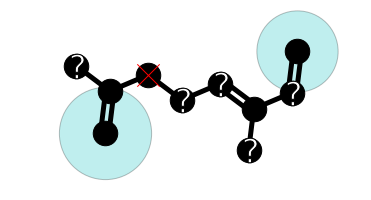

0 1 DOUBLE
1 2 SINGLE
2 3 SINGLE
3 4 SINGLE
4 5 SINGLE
5 6 SINGLE
5 7 SINGLE

1 <type 'int'>
True
Has kinetics Arrhenius(A=(129.066,'cm^3/(mol*s)'), n=3.1053, Ea=(21.2672,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.22903, dn = +|- 0.0270653, dEa = +|- 0.148886 kJ/mol""")

nan <type 'float'>
False

nan <type 'float'>
False

nan <type 'float'>
False

nan <type 'float'>
False

1 <type 'int'>
True
Has kinetics Arrhenius(A=(75493.8,'cm^3/(mol*s)'), n=2.6706, Ea=(13.3381,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.32133, dn = +|- 0.0365685, dEa = +|- 0.201164 kJ/mol""")

1 <type 'int'>
True
Has kinetics Arrhenius(A=(87.1271,'cm^3/(mol*s)'), n=2.97097, Ea=(38.3978,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.19598, dn = +|- 0.0234879, dEa = +|- 0.129207 kJ/mol""")

1 <type 'int'>
True
Has kinetics Arrhenius(

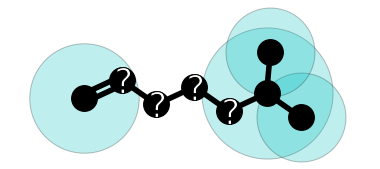

0 1 SINGLE
1 2 DOUBLE
1 3 SINGLE
3 4 SINGLE
3 5 SINGLE
5 6 SINGLE
6 7 SINGLE
6 8 SINGLE

nan <type 'float'>
False

nan <type 'float'>
False

nan <type 'float'>
False

nan <type 'float'>
False

1 <type 'int'>
True
Has kinetics Arrhenius(A=(60383,'cm^3/(mol*s)'), n=2.8308, Ea=(19.9317,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.44376, dn = +|- 0.0481981, dEa = +|- 0.265138 kJ/mol""")

1 <type 'int'>
True
Has kinetics Arrhenius(A=(13.9091,'cm^3/(mol*s)'), n=3.03139, Ea=(44.5471,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.27788, dn = +|- 0.0321807, dEa = +|- 0.177026 kJ/mol""")

1 <type 'int'>
True
Has kinetics Arrhenius(A=(13.9091,'cm^3/(mol*s)'), n=3.03139, Ea=(44.5471,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.27788, dn = +|- 0.0321807, dEa = +|- 0.177026 kJ/mol""")


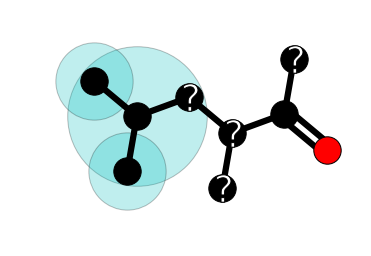

0 1 SINGLE
1 2 DOUBLE
1 3 SINGLE
3 4 SINGLE
4 5 SINGLE
5 6 SINGLE
6 7 SINGLE
6 8 SINGLE

nan <type 'float'>
False

nan <type 'float'>
False

nan <type 'float'>
False

nan <type 'float'>
False

1 <type 'int'>
True
Has kinetics Arrhenius(A=(15.5222,'cm^3/(mol*s)'), n=3.12152, Ea=(39.5113,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.28346, dn = +|- 0.0327527, dEa = +|- 0.180173 kJ/mol""")

1 <type 'int'>
True
Has kinetics Arrhenius(A=(15.5222,'cm^3/(mol*s)'), n=3.12152, Ea=(39.5113,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.28346, dn = +|- 0.0327527, dEa = +|- 0.180173 kJ/mol""")


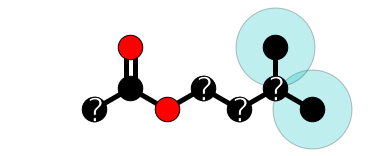

0 1 SINGLE
1 2 SINGLE
1 3 SINGLE
1 4 SINGLE
4 5 SINGLE
5 6 SINGLE
6 7 SINGLE
7 8 SINGLE
6 9 SINGLE
9 10 SINGLE
10 11 SINGLE
10 12 SINGLE
10 13 SINGLE

nan <type 'float'>
False

nan <type 'float'>
False

nan <type 'float'>
False

nan <type 'float'>
False

nan <type 'float'>
False

nan <type 'float'>
False

nan <type 'float'>
False

nan <type 'float'>
False

nan <type 'float'>
False

nan <type 'float'>
False


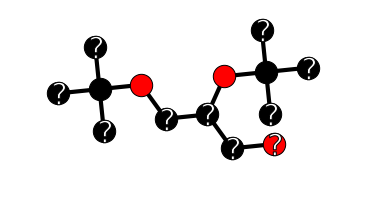

0 1 SINGLE
1 2 SINGLE
1 3 SINGLE
3 4 SINGLE
4 5 DOUBLE
4 6 SINGLE
6 7 SINGLE
7 8 SINGLE
7 9 SINGLE

1 <type 'int'>
True
Has kinetics Arrhenius(A=(12.0731,'cm^3/(mol*s)'), n=3.08834, Ea=(35.2036,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.27154, dn = +|- 0.0315274, dEa = +|- 0.173432 kJ/mol""")

0 <type 'int'>
False
failed

1 <type 'int'>
True
Has kinetics Arrhenius(A=(12.0731,'cm^3/(mol*s)'), n=3.08834, Ea=(35.2036,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.27154, dn = +|- 0.0315274, dEa = +|- 0.173432 kJ/mol""")

nan <type 'float'>
False

nan <type 'float'>
False

0 <type 'int'>
False
failed

1 <type 'int'>
True
Has kinetics Arrhenius(A=(12.0731,'cm^3/(mol*s)'), n=3.08834, Ea=(35.2036,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.27154, dn = +|- 0.0315274, dEa = +|- 0.173432 kJ/mol""")

1 <type 'int'

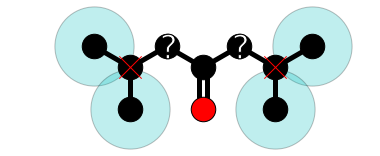

0 1 SINGLE
1 2 SINGLE
1 3 SINGLE
3 4 SINGLE
4 5 SINGLE
4 6 SINGLE
4 7 SINGLE

1 <type 'int'>
True
Has kinetics Arrhenius(A=(0.0519304,'cm^3/(mol*s)'), n=4.08654, Ea=(53.5167,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.34509, dn = +|- 0.0389074, dEa = +|- 0.21403 kJ/mol""")

nan <type 'float'>
False

1 <type 'int'>
True
Has kinetics Arrhenius(A=(0.0519304,'cm^3/(mol*s)'), n=4.08654, Ea=(53.5167,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.34509, dn = +|- 0.0389074, dEa = +|- 0.21403 kJ/mol""")

nan <type 'float'>
False

nan <type 'float'>
False

nan <type 'float'>
False

nan <type 'float'>
False


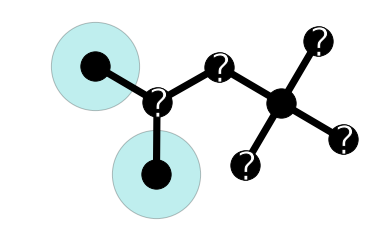

0 1 SINGLE
1 2 DOUBLE
2 3 SINGLE
3 4 SINGLE
4 5 SINGLE
5 6 SINGLE
6 7 SINGLE
7 8 SINGLE
7 9 SINGLE
6 1 SINGLE
7 4 SINGLE

nan <type 'float'>
False

nan <type 'float'>
False

nan <type 'float'>
False

nan <type 'float'>
False

nan <type 'float'>
False

nan <type 'float'>
False

nan <type 'float'>
False

nan <type 'float'>
False


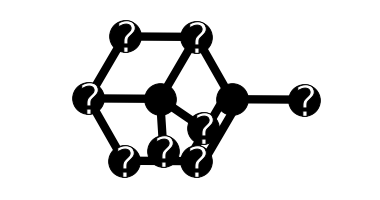

0 1 SINGLE
1 2 DOUBLE
2 3 SINGLE
3 4 SINGLE
4 5 SINGLE
5 6 DOUBLE
5 1 SINGLE

nan <type 'float'>
False

nan <type 'float'>
False

1 <type 'int'>
True
Has kinetics Arrhenius(A=(1302.28,'cm^3/(mol*s)'), n=3.05883, Ea=(11.0432,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.55866, dn = +|- 0.0582479, dEa = +|- 0.320422 kJ/mol""")

nan <type 'float'>
False


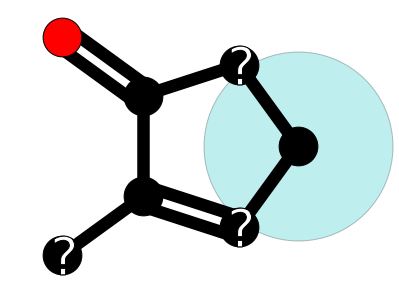

0 1 SINGLE
1 2 AROMATIC
2 3 AROMATIC
3 4 AROMATIC
4 5 SINGLE
4 6 AROMATIC
6 7 AROMATIC
7 1 AROMATIC


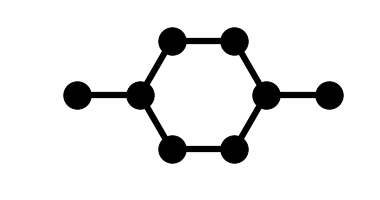

0 1 SINGLE
1 2 SINGLE
2 3 SINGLE
3 4 SINGLE
4 5 SINGLE
5 1 SINGLE

1 <type 'int'>
True
Has kinetics Arrhenius(A=(0.126947,'cm^3/(mol*s)'), n=4.10394, Ea=(34.1844,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.2523, dn = +|- 0.0295272, dEa = +|- 0.162429 kJ/mol""")

1 <type 'int'>
True
Has kinetics Arrhenius(A=(211.539,'cm^3/(mol*s)'), n=2.8133, Ea=(48.9495,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.03942, dn = +|- 0.00507363, dEa = +|- 0.02791 kJ/mol""")

1 <type 'int'>
True
Has kinetics Arrhenius(A=(214.839,'cm^3/(mol*s)'), n=2.91847, Ea=(48.33,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.12881, dn = +|- 0.015902, dEa = +|- 0.0874768 kJ/mol""")

1 <type 'int'>
True
Has kinetics Arrhenius(A=(323.975,'cm^3/(mol*s)'), n=2.83973, Ea=(47.2527,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), commen

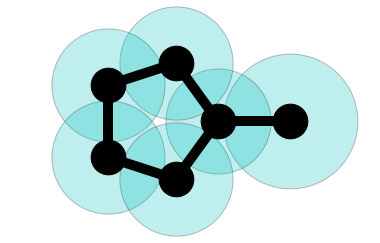

0 1 SINGLE
1 2 DOUBLE
2 3 SINGLE
3 4 SINGLE
4 5 SINGLE
5 6 SINGLE
5 7 SINGLE

nan <type 'float'>
False

nan <type 'float'>
False

nan <type 'float'>
False

nan <type 'float'>
False

nan <type 'float'>
False

1 <type 'int'>
True
Has kinetics Arrhenius(A=(144384,'cm^3/(mol*s)'), n=2.67445, Ea=(13.1092,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.31791, dn = +|- 0.0362288, dEa = +|- 0.199295 kJ/mol""")

1 <type 'int'>
True
Has kinetics Arrhenius(A=(30.0908,'cm^3/(mol*s)'), n=2.9816, Ea=(42.8628,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.24407, dn = +|- 0.0286612, dEa = +|- 0.157665 kJ/mol""")

1 <type 'int'>
True
Has kinetics Arrhenius(A=(30.0908,'cm^3/(mol*s)'), n=2.9816, Ea=(42.8628,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.24407, dn = +|- 0.0286612, dEa = +|- 0.157665 kJ/mol""")


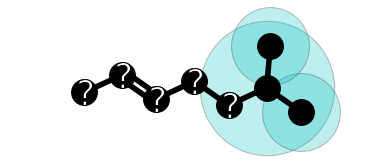

0 1 SINGLE
1 2 SINGLE
2 3 SINGLE
2 4 SINGLE
2 5 SINGLE

nan <type 'float'>
False

1 <type 'int'>
True
Has kinetics Arrhenius(A=(16.7747,'cm^3/(mol*s)'), n=3.00212, Ea=(41.5988,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.16288, dn = +|- 0.0198048, dEa = +|- 0.108946 kJ/mol""")

nan <type 'float'>
False

nan <type 'float'>
False

1 <type 'int'>
True
Has kinetics Arrhenius(A=(3.16539,'cm^3/(mol*s)'), n=3.50164, Ea=(21.6872,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.44662, dn = +|- 0.0484577, dEa = +|- 0.266566 kJ/mol""")


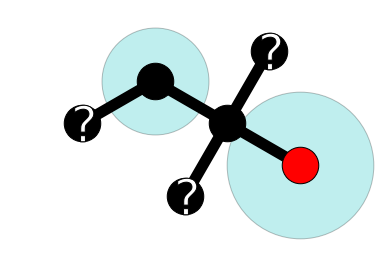

0 1 SINGLE
1 2 SINGLE
2 3 SINGLE
2 4 SINGLE
4 5 SINGLE
5 6 SINGLE
5 7 SINGLE

1 <type 'int'>
True
Has kinetics Arrhenius(A=(47.0331,'cm^3/(mol*s)'), n=2.95987, Ea=(40.6467,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.21882, dn = +|- 0.0259702, dEa = +|- 0.142862 kJ/mol""")

nan <type 'float'>
False

1 <type 'int'>
True
Has kinetics Arrhenius(A=(75375,'cm^3/(mol*s)'), n=2.70645, Ea=(20.6266,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.38013, dn = +|- 0.0422829, dEa = +|- 0.232598 kJ/mol""")

1 <type 'int'>
True
Has kinetics Arrhenius(A=(38.7877,'cm^3/(mol*s)'), n=3.07235, Ea=(40.817,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.24913, dn = +|- 0.029194, dEa = +|- 0.160596 kJ/mol""")

nan <type 'float'>
False

nan <type 'float'>
False

1 <type 'int'>
True
Has kinetics Arrhenius(A=(7.27037,'cm^3/(mol*s)'), 

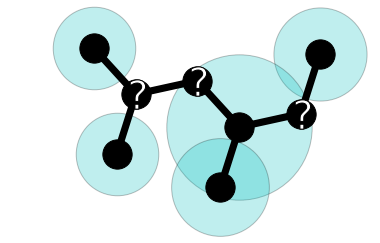

0 1 SINGLE
1 2 SINGLE
2 3 SINGLE
3 4 SINGLE
2 5 SINGLE
5 6 SINGLE
6 7 SINGLE
6 8 SINGLE

nan <type 'float'>
False

nan <type 'float'>
False

0 <type 'int'>
False
failed

nan <type 'float'>
False

nan <type 'float'>
False

nan <type 'float'>
False

nan <type 'float'>
False

nan <type 'float'>
False


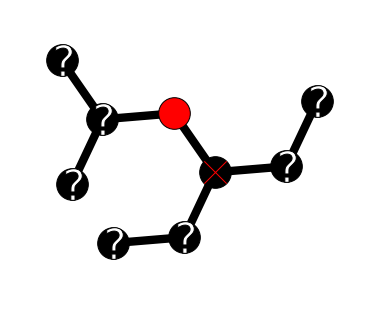

0 1 SINGLE
1 2 SINGLE
2 3 DOUBLE
3 4 SINGLE
4 5 SINGLE
5 6 SINGLE
5 7 SINGLE

nan <type 'float'>
False

nan <type 'float'>
False

nan <type 'float'>
False

nan <type 'float'>
False

nan <type 'float'>
False

0 <type 'int'>
False
failed

1 <type 'int'>
True
Has kinetics Arrhenius(A=(7.32107,'cm^3/(mol*s)'), n=3.16128, Ea=(43.4182,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.36649, dn = +|- 0.0409791, dEa = +|- 0.225426 kJ/mol""")

1 <type 'int'>
True
Has kinetics Arrhenius(A=(7.32107,'cm^3/(mol*s)'), n=3.16128, Ea=(43.4182,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.36649, dn = +|- 0.0409791, dEa = +|- 0.225426 kJ/mol""")


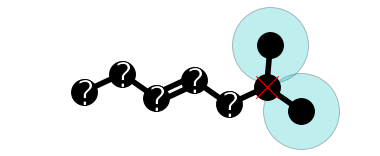

0 1 SINGLE
1 2 SINGLE
2 3 SINGLE
3 4 SINGLE
3 5 SINGLE
5 6 DOUBLE
6 7 SINGLE
6 8 SINGLE

1 <type 'int'>
True
Has kinetics Arrhenius(A=(0.0230437,'cm^3/(mol*s)'), n=4.16118, Ea=(54.5338,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.42861, dn = +|- 0.0468137, dEa = +|- 0.257522 kJ/mol""")

nan <type 'float'>
False

nan <type 'float'>
False

nan <type 'float'>
False

nan <type 'float'>
False

nan <type 'float'>
False

nan <type 'float'>
False

nan <type 'float'>
False


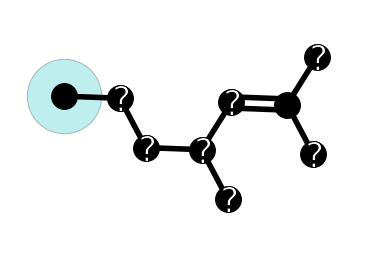

0 1 SINGLE
1 2 SINGLE
2 3 SINGLE
3 4 SINGLE
3 5 SINGLE
5 6 SINGLE

1 <type 'int'>
True
Has kinetics Arrhenius(A=(5.74562,'cm^3/(mol*s)'), n=2.98795, Ea=(45.8829,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.28745, dn = +|- 0.03316, dEa = +|- 0.182413 kJ/mol""")

nan <type 'float'>
False

1 <type 'int'>
True
Has kinetics Arrhenius(A=(15.6413,'cm^3/(mol*s)'), n=2.98431, Ea=(51.0335,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.18514, dn = +|- 0.0222929, dEa = +|- 0.122633 kJ/mol""")

0 <type 'int'>
False
failed

nan <type 'float'>
False

nan <type 'float'>
False

1 <type 'int'>
True
Has kinetics Arrhenius(A=(0.00130455,'cm^3/(mol*s)'), n=4.42888, Ea=(31.3679,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.61742, dn = +|- 0.0631052, dEa = +|- 0.347142 kJ/mol""")


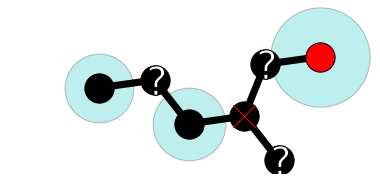

0 1 SINGLE
1 2 SINGLE
2 3 SINGLE
3 4 DOUBLE
4 5 SINGLE
5 6 SINGLE
5 7 SINGLE

1 <type 'int'>
True
Has kinetics Arrhenius(A=(100.834,'cm^3/(mol*s)'), n=3.02487, Ea=(38.3691,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.22937, dn = +|- 0.0271019, dEa = +|- 0.149088 kJ/mol""")

nan <type 'float'>
False

nan <type 'float'>
False

nan <type 'float'>
False

nan <type 'float'>
False

1 <type 'int'>
True
Has kinetics Arrhenius(A=(102484,'cm^3/(mol*s)'), n=2.53696, Ea=(6.78445,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.2343, dn = +|- 0.0276269, dEa = +|- 0.151976 kJ/mol""")

nan <type 'float'>
False

nan <type 'float'>
False


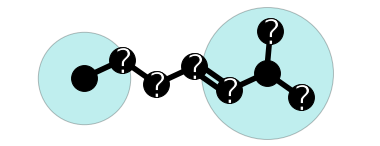

0 1 SINGLE
1 2 SINGLE
2 3 SINGLE
3 4 SINGLE
4 5 SINGLE
4 6 SINGLE
6 7 SINGLE

1 <type 'int'>
True
Has kinetics Arrhenius(A=(27.1191,'cm^3/(mol*s)'), n=3.03795, Ea=(36.578,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.24074, dn = +|- 0.0283093, dEa = +|- 0.155729 kJ/mol""")

nan <type 'float'>
False

nan <type 'float'>
False

nan <type 'float'>
False

1 <type 'int'>
True
Has kinetics Arrhenius(A=(3945.43,'cm^3/(mol*s)'), n=2.74586, Ea=(19.3425,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.43827, dn = +|- 0.0476981, dEa = +|- 0.262388 kJ/mol""")

1 <type 'int'>
True
Has kinetics Arrhenius(A=(34.2725,'cm^3/(mol*s)'), n=3.04717, Ea=(42.3862,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.24076, dn = +|- 0.0283116, dEa = +|- 0.155742 kJ/mol""")

nan <type 'float'>
False

1 <type 'int'>
True
Has kinetics Arrhenius

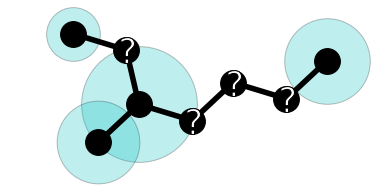

0 1 SINGLE
1 2 SINGLE
2 3 SINGLE
3 4 SINGLE
4 5 DOUBLE
5 6 SINGLE
5 7 SINGLE

1 <type 'int'>
True
Has kinetics Arrhenius(A=(9.52626,'cm^3/(mol*s)'), n=3.02919, Ea=(41.0275,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.24975, dn = +|- 0.0292593, dEa = +|- 0.160956 kJ/mol""")

nan <type 'float'>
False

1 <type 'int'>
True
Has kinetics Arrhenius(A=(1197.31,'cm^3/(mol*s)'), n=3.73752, Ea=(16.7675,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.36184, dn = +|- 0.0405319, dEa = +|- 0.222966 kJ/mol""")

nan <type 'float'>
False

nan <type 'float'>
False

nan <type 'float'>
False

nan <type 'float'>
False


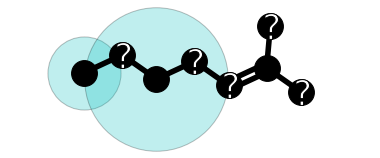

0 1 SINGLE
1 2 SINGLE
2 3 SINGLE
3 4 SINGLE
4 5 SINGLE
5 6 SINGLE
6 7 SINGLE
7 8 SINGLE
8 9 SINGLE
8 10 SINGLE
10 5 SINGLE

1 <type 'int'>
True
Has kinetics Arrhenius(A=(25.2111,'cm^3/(mol*s)'), n=2.99202, Ea=(40.6643,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.27118, dn = +|- 0.0314907, dEa = +|- 0.17323 kJ/mol""")

nan <type 'float'>
False

nan <type 'float'>
False

1 <type 'int'>
True
Has kinetics Arrhenius(A=(0.645563,'cm^3/(mol*s)'), n=3.94545, Ea=(43.7738,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.17926, dn = +|- 0.0216397, dEa = +|- 0.11904 kJ/mol""")

1 <type 'int'>
True
Has kinetics Arrhenius(A=(416.138,'cm^3/(mol*s)'), n=2.98766, Ea=(46.2252,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.17476, dn = +|- 0.0211385, dEa = +|- 0.116283 kJ/mol""")

1 <type 'int'>
True
Has kinetics Arrhenius(A=(54

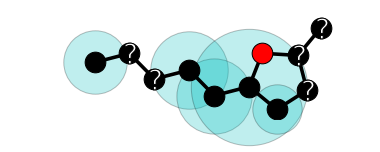

0 1 SINGLE
1 2 SINGLE
2 3 SINGLE
3 4 DOUBLE
3 5 SINGLE
5 6 SINGLE
5 7 SINGLE

1 <type 'int'>
True
Has kinetics Arrhenius(A=(7.11586,'cm^3/(mol*s)'), n=3.21123, Ea=(30.9339,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.33096, dn = +|- 0.0375223, dEa = +|- 0.20641 kJ/mol""")

nan <type 'float'>
False

nan <type 'float'>
False

nan <type 'float'>
False

nan <type 'float'>
False


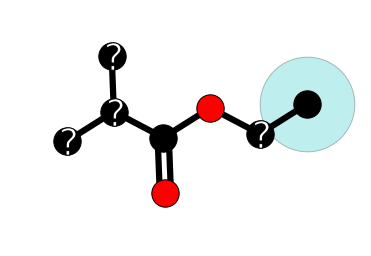

0 1 SINGLE

1 <type 'int'>
True
Has kinetics Arrhenius(A=(165.058,'cm^3/(mol*s)'), n=3.26741, Ea=(4.25087,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.57377, dn = +|- 0.0595145, dEa = +|- 0.327389 kJ/mol""")

1 <type 'int'>
True
Has kinetics Arrhenius(A=(165.058,'cm^3/(mol*s)'), n=3.26741, Ea=(4.25087,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.57377, dn = +|- 0.0595145, dEa = +|- 0.327389 kJ/mol""")


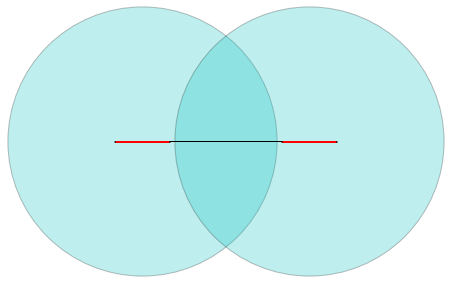

In [8]:
# this is for all molecule of a specifc abstractor 


abstractor = "[H]"
for parent in list_of_parents:
    try:
        parent_rdmol = rdkit.Chem.AllChem.MolFromSmiles(parent)
        parent_rdmol.Compute2DCoords()
        tup = parent_rdmol.GetConformers()
        rdconformer = tup[0]
        radical_rdmol = parent_rdmol.__copy__()
        
        fig, ax = plt.subplots(figsize=(6,6), dpi=120)

        # Plotting the atoms of the molecule
        for atom in parent_rdmol.GetAtoms():
            atom_index = atom.GetIdx()

            if atom.GetAtomicNum() == 6:
                plt.scatter(rdconformer.GetAtomPosition(atom_index).x, rdconformer.GetAtomPosition(atom_index).y, c="k", alpha=1, zorder=0)
            elif atom.GetAtomicNum() == 7:
                plt.scatter(rdconformer.GetAtomPosition(atom_index).x, rdconformer.GetAtomPosition(atom_index).y, c="b", alpha=1, zorder=0)
            elif atom.GetAtomicNum() == 8:
                plt.scatter(rdconformer.GetAtomPosition(atom_index).x, rdconformer.GetAtomPosition(atom_index).y, c="r", alpha=1, zorder=0)


        # Plotting the bonds of the molecule
        ax.set_aspect('equal')
        lim = ax.get_xlim()
        lim2 = ax.get_ylim()
        
        if lim > lim2:
            lim = lim2
        diff = abs(lim[0] - lim[1])
        size = 6000 / (diff)
        thick = 50./ (diff)
        
        for atom in parent_rdmol.GetAtoms():
            atom_index = atom.GetIdx()
        
            if atom.GetAtomicNum() == 6:
                plt.scatter(rdconformer.GetAtomPosition(atom_index).x, rdconformer.GetAtomPosition(atom_index).y, c="k", s=size, alpha=1, zorder=10)
            elif atom.GetAtomicNum() == 7:
                plt.scatter(rdconformer.GetAtomPosition(atom_index).x, rdconformer.GetAtomPosition(atom_index).y, c="b", s=size, alpha=1, zorder=10)
            elif atom.GetAtomicNum() == 8:
                plt.scatter(rdconformer.GetAtomPosition(atom_index).x, rdconformer.GetAtomPosition(atom_index).y, c="r", s=size, alpha=1, zorder=10)

        for bond in parent_rdmol.GetBonds():
            print bond.GetBeginAtomIdx(), bond.GetEndAtomIdx(), bond.GetBondType()
            if str(bond.GetBondType()) == "SINGLE" or str(bond.GetBondType()) == "AROMATIC" :
                new_x = [
                    rdconformer.GetAtomPosition(bond.GetBeginAtomIdx()).x,
                    rdconformer.GetAtomPosition(bond.GetEndAtomIdx()).x
                ]
                new_y = [
                    rdconformer.GetAtomPosition(bond.GetBeginAtomIdx()).y,
                    rdconformer.GetAtomPosition(bond.GetEndAtomIdx()).y
                ]

                plt.plot(new_x, new_y, "k", alpha=1,zorder=1, linewidth=thick)

            elif str(bond.GetBondType()) == "DOUBLE":
                rise = rdconformer.GetAtomPosition(bond.GetBeginAtomIdx()).y - rdconformer.GetAtomPosition(bond.GetEndAtomIdx()).y
                run = rdconformer.GetAtomPosition(bond.GetBeginAtomIdx()).x - rdconformer.GetAtomPosition(bond.GetEndAtomIdx()).x


                del_y = sympy.Symbol('del_y')
                try:
                    a = sympy.solvers.solve(0.1**2 - (- (rise/run) * del_y)**2 - del_y**2, del_y)
                    del_x = - (rise/run) * a[0]
                    v_1 = 0.15 * del_x / (del_x**2 + a[0]**2)**0.5
                    v_2 = 0.15 * a[0] / (del_x**2 + a[0]**2)**0.5
                except ZeroDivisionError:
                    v_1 = 0.15
                    v_2 = 0

                new_x = [
                    rdconformer.GetAtomPosition(bond.GetBeginAtomIdx()).x + v_1, 
                    rdconformer.GetAtomPosition(bond.GetEndAtomIdx()).x + v_1
                ]
                new_y = [
                    rdconformer.GetAtomPosition(bond.GetBeginAtomIdx()).y + v_2, 
                    rdconformer.GetAtomPosition(bond.GetEndAtomIdx()).y + v_2
                ]

                newnew_x = [
                    rdconformer.GetAtomPosition(bond.GetBeginAtomIdx()).x - v_1, 
                    rdconformer.GetAtomPosition(bond.GetEndAtomIdx()).x - v_1
                ]
                newnew_y = [
                    rdconformer.GetAtomPosition(bond.GetBeginAtomIdx()).y - v_2, 
                    rdconformer.GetAtomPosition(bond.GetEndAtomIdx()).y - v_2
                ]

                plt.plot(new_x, new_y, "k", alpha=1, zorder=1, linewidth=thick)
                plt.plot(newnew_x, newnew_y, "k", alpha=1, zorder=1, linewidth=thick)

            elif str(bond.GetBondType()) == "TRIPLE":

                rise = rdconformer.GetAtomPosition(bond.GetBeginAtomIdx()).y - rdconformer.GetAtomPosition(bond.GetEndAtomIdx()).y
                run = rdconformer.GetAtomPosition(bond.GetBeginAtomIdx()).x - rdconformer.GetAtomPosition(bond.GetEndAtomIdx()).x



                del_y = sympy.Symbol('del_y')
                a = sympy.solvers.solve(0.1**2 - (- (rise/run) * del_y)**2 - del_y**2, del_y)
                del_x = - (rise/run) * a[0]
                dell_x = - (rise/run) * a[1]
                v_1 = 0.19 * del_x / (del_x**2 + a[0]**2)**0.5
                v_2 = 0.19 * a[0] / (del_x**2 + a[0]**2)**0.5

                new_x = [
                    rdconformer.GetAtomPosition(bond.GetBeginAtomIdx()).x,
                    rdconformer.GetAtomPosition(bond.GetEndAtomIdx()).x
                ]
                new_y = [
                    rdconformer.GetAtomPosition(bond.GetBeginAtomIdx()).y,
                    rdconformer.GetAtomPosition(bond.GetEndAtomIdx()).y
                ]

                newnew_x = [
                    rdconformer.GetAtomPosition(bond.GetBeginAtomIdx()).x + v_1, 
                    rdconformer.GetAtomPosition(bond.GetEndAtomIdx()).x + v_1
                ]
                newnew_y = [
                    rdconformer.GetAtomPosition(bond.GetBeginAtomIdx()).y + v_2, 
                    rdconformer.GetAtomPosition(bond.GetEndAtomIdx()).y + v_2
                ]

                newnewnew_x = [
                    rdconformer.GetAtomPosition(bond.GetBeginAtomIdx()).x - v_1, 
                    rdconformer.GetAtomPosition(bond.GetEndAtomIdx()).x - v_1
                ]
                newnewnew_y = [
                    rdconformer.GetAtomPosition(bond.GetBeginAtomIdx()).y - v_2, 
                    rdconformer.GetAtomPosition(bond.GetEndAtomIdx()).y - v_2
                ]

                plt.plot(new_x, new_y, "k", alpha=1, zorder=1, linewidth=thick)
                plt.plot(newnew_x, newnew_y, "k", alpha=1, zorder=1, linewidth=thick)
                plt.plot(newnewnew_x, newnewnew_y, "k", alpha=1, zorder=1, linewidth=thick)

        for atom in parent_rdmol.GetAtoms():
            if atom.GetNumImplicitHs() != 0:
                atom_index = atom.GetIdx()

                radical_rdmol = parent_rdmol.__copy__()

                radical_rdmol.GetAtomWithIdx(atom_index).SetNumRadicalElectrons(1)
                radical_smiles = rdkit.Chem.AllChem.MolToSmiles(radical_rdmol)

                has_kinetics = df[((df["Abstractor"] == abstractor) & (df["Radical Molecule"] == radical_smiles))].loc[parent]["Has Kinetics"]
                kinetics = df[((df["Abstractor"] == abstractor) & (df["Radical Molecule"] == radical_smiles))].loc[parent]["Arrhenius Expression"]

                #Plotting a ? if there is no kinetics
                print 
                print has_kinetics, type(has_kinetics)
                print has_kinetics == 1
                if not has_kinetics > -1:
                    plt.scatter(rdconformer.GetAtomPosition(atom_index).x, rdconformer.GetAtomPosition(atom_index).y, c="w", s=size, alpha=1, zorder=10, marker="$?$")
                    #plt.show()
                elif has_kinetics == float(0):
                    print "failed"
                    plt.scatter(rdconformer.GetAtomPosition(atom_index).x, rdconformer.GetAtomPosition(atom_index).y, marker="x", s=500, c="r", zorder=10000)
                    #plt.show()
                elif has_kinetics == float(1):
                    print "Has kinetics", kinetics
                    rate = np.log10(kinetics.getRateCoefficient(T=1000, P=1e5))*500*thick 
                    plt.scatter(rdconformer.GetAtomPosition(atom_index).x, rdconformer.GetAtomPosition(atom_index).y, s=rate, c='c', alpha=0.25, zorder=0, clip_on=False)
        
        lim = ax.get_xlim()
        lim2 = ax.get_ylim()
        ax.set_xlim(lim*2)
        ax.set_ylim(lim2*2)
        #plt.axis("off")
        plt.tight_layout()
        plt.show()
                    
    except:
        plt.axis("off")
        plt.show()
        pass

## Plotting all abstractors for a single molecule

[O]
0 1 SINGLE
1 2 SINGLE
2 3 SINGLE
2 4 SINGLE
2 5 SINGLE

nan <type 'float'>
False

0 <type 'int'>
False
failed

nan <type 'float'>
False

nan <type 'float'>
False

nan <type 'float'>
False


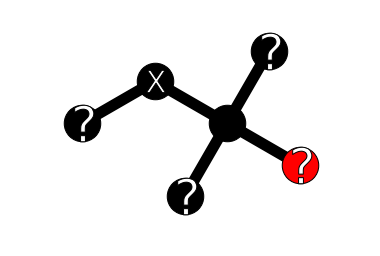

[CH3]
0 1 SINGLE
1 2 SINGLE
2 3 SINGLE
2 4 SINGLE
2 5 SINGLE

nan <type 'float'>
False

1 <type 'int'>
True
Has kinetics Arrhenius(A=(1.91266e-05,'cm^3/(mol*s)'), n=4.69825, Ea=(52.8398,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.76271, dn = +|- 0.074394, dEa = +|- 0.409242 kJ/mol""")

nan <type 'float'>
False

nan <type 'float'>
False

1 <type 'int'>
True
Has kinetics Arrhenius(A=(1.40198e-05,'cm^3/(mol*s)'), n=5.09382, Ea=(21.3959,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.97417, dn = +|- 0.0892634, dEa = +|- 0.491038 kJ/mol""")


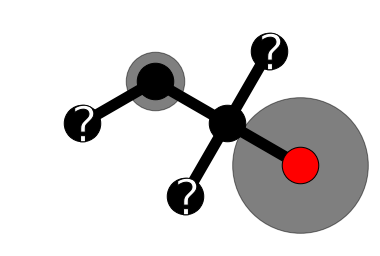

[O]O
0 1 SINGLE
1 2 SINGLE
2 3 SINGLE
2 4 SINGLE
2 5 SINGLE

1 <type 'int'>
True
Has kinetics Arrhenius(A=(0.00115121,'cm^3/(mol*s)'), n=4.04239, Ea=(0.907152,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.19463, dn = +|- 0.0233399, dEa = +|- 0.128393 kJ/mol""")

1 <type 'int'>
True
Has kinetics Arrhenius(A=(0.00497261,'cm^3/(mol*s)'), n=3.86176, Ea=(-2.43365,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.06167, dn = +|- 0.00785357, dEa = +|- 0.0432025 kJ/mol""")

1 <type 'int'>
True
Has kinetics Arrhenius(A=(0.119972,'cm^3/(mol*s)'), n=3.41825, Ea=(-5.51816,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.11135, dn = +|- 0.0138559, dEa = +|- 0.0762215 kJ/mol""")

1 <type 'int'>
True
Has kinetics Arrhenius(A=(0.119972,'cm^3/(mol*s)'), n=3.41825, Ea=(-5.51816,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,

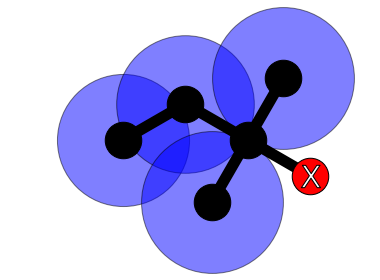

[H]
0 1 SINGLE
1 2 SINGLE
2 3 SINGLE
2 4 SINGLE
2 5 SINGLE

nan <type 'float'>
False

1 <type 'int'>
True
Has kinetics Arrhenius(A=(16.7747,'cm^3/(mol*s)'), n=3.00212, Ea=(41.5988,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.16288, dn = +|- 0.0198048, dEa = +|- 0.108946 kJ/mol""")

nan <type 'float'>
False

nan <type 'float'>
False

1 <type 'int'>
True
Has kinetics Arrhenius(A=(3.16539,'cm^3/(mol*s)'), n=3.50164, Ea=(21.6872,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.44662, dn = +|- 0.0484577, dEa = +|- 0.266566 kJ/mol""")


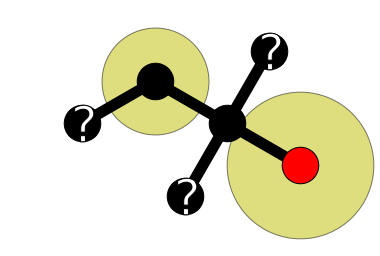

[OH]
0 1 SINGLE
1 2 SINGLE
2 3 SINGLE
2 4 SINGLE
2 5 SINGLE

nan <type 'float'>
False

1 <type 'int'>
True
Has kinetics Arrhenius(A=(1918.82,'cm^3/(mol*s)'), n=2.92564, Ea=(-4.51539,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.05404, dn = +|- 0.00690778, dEa = +|- 0.0379997 kJ/mol""")

nan <type 'float'>
False

nan <type 'float'>
False

nan <type 'float'>
False


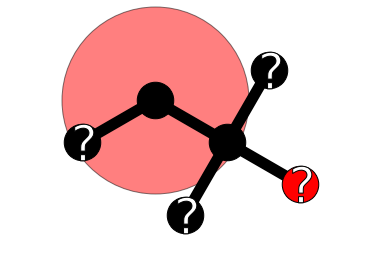

[O][O]
0 1 SINGLE
1 2 SINGLE
2 3 SINGLE
2 4 SINGLE
2 5 SINGLE


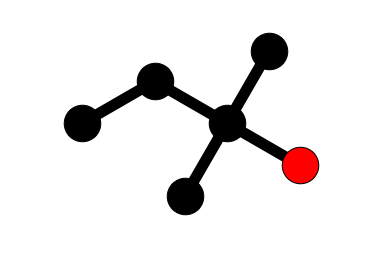

In [9]:
# this is for all molecule of a specifc abstractor 


parent = "CCC(C)(C)O"
for abstractor in list_of_abstractors:
    print abstractor
    try:
        parent_rdmol = rdkit.Chem.AllChem.MolFromSmiles(parent)
        parent_rdmol.Compute2DCoords()
        tup = parent_rdmol.GetConformers()
        rdconformer = tup[0]
        radical_rdmol = parent_rdmol.__copy__()
        
        fig, ax = plt.subplots(figsize=(6,6), dpi=120)

        # Plotting the atoms of the molecule
        for atom in parent_rdmol.GetAtoms():
            atom_index = atom.GetIdx()

            if atom.GetAtomicNum() == 6:
                plt.scatter(rdconformer.GetAtomPosition(atom_index).x, rdconformer.GetAtomPosition(atom_index).y, c="k", alpha=1, zorder=0)
            elif atom.GetAtomicNum() == 7:
                plt.scatter(rdconformer.GetAtomPosition(atom_index).x, rdconformer.GetAtomPosition(atom_index).y, c="b", alpha=1, zorder=0)
            elif atom.GetAtomicNum() == 8:
                plt.scatter(rdconformer.GetAtomPosition(atom_index).x, rdconformer.GetAtomPosition(atom_index).y, c="r", alpha=1, zorder=0)


        # Plotting the bonds of the molecule
        ax.set_aspect('equal')
        lim = ax.get_xlim()
        lim2 = ax.get_ylim()
        
        if lim > lim2:
            lim = lim2
        diff = abs(lim[0] - lim[1])
        size = 6000 / (diff)
        thick = 50./ (diff)
        
        for atom in parent_rdmol.GetAtoms():
            atom_index = atom.GetIdx()
        
            if atom.GetAtomicNum() == 6:
                plt.scatter(rdconformer.GetAtomPosition(atom_index).x, rdconformer.GetAtomPosition(atom_index).y, c="k", s=size, alpha=1, zorder=10)
            elif atom.GetAtomicNum() == 7:
                plt.scatter(rdconformer.GetAtomPosition(atom_index).x, rdconformer.GetAtomPosition(atom_index).y, c="b", s=size, alpha=1, zorder=10)
            elif atom.GetAtomicNum() == 8:
                plt.scatter(rdconformer.GetAtomPosition(atom_index).x, rdconformer.GetAtomPosition(atom_index).y, c="r", s=size, alpha=1, zorder=10)

        for bond in parent_rdmol.GetBonds():
            print bond.GetBeginAtomIdx(), bond.GetEndAtomIdx(), bond.GetBondType()
            if str(bond.GetBondType()) == "SINGLE" or str(bond.GetBondType()) == "AROMATIC" :
                new_x = [
                    rdconformer.GetAtomPosition(bond.GetBeginAtomIdx()).x,
                    rdconformer.GetAtomPosition(bond.GetEndAtomIdx()).x
                ]
                new_y = [
                    rdconformer.GetAtomPosition(bond.GetBeginAtomIdx()).y,
                    rdconformer.GetAtomPosition(bond.GetEndAtomIdx()).y
                ]

                plt.plot(new_x, new_y, "k", alpha=1,zorder=1, linewidth=thick)

            elif str(bond.GetBondType()) == "DOUBLE":
                rise = rdconformer.GetAtomPosition(bond.GetBeginAtomIdx()).y - rdconformer.GetAtomPosition(bond.GetEndAtomIdx()).y
                run = rdconformer.GetAtomPosition(bond.GetBeginAtomIdx()).x - rdconformer.GetAtomPosition(bond.GetEndAtomIdx()).x


                del_y = sympy.Symbol('del_y')
                try:
                    a = sympy.solvers.solve(0.1**2 - (- (rise/run) * del_y)**2 - del_y**2, del_y)
                    del_x = - (rise/run) * a[0]
                    v_1 = 0.15 * del_x / (del_x**2 + a[0]**2)**0.5
                    v_2 = 0.15 * a[0] / (del_x**2 + a[0]**2)**0.5
                except ZeroDivisionError:
                    v_1 = 0.15
                    v_2 = 0

                new_x = [
                    rdconformer.GetAtomPosition(bond.GetBeginAtomIdx()).x + v_1, 
                    rdconformer.GetAtomPosition(bond.GetEndAtomIdx()).x + v_1
                ]
                new_y = [
                    rdconformer.GetAtomPosition(bond.GetBeginAtomIdx()).y + v_2, 
                    rdconformer.GetAtomPosition(bond.GetEndAtomIdx()).y + v_2
                ]

                newnew_x = [
                    rdconformer.GetAtomPosition(bond.GetBeginAtomIdx()).x - v_1, 
                    rdconformer.GetAtomPosition(bond.GetEndAtomIdx()).x - v_1
                ]
                newnew_y = [
                    rdconformer.GetAtomPosition(bond.GetBeginAtomIdx()).y - v_2, 
                    rdconformer.GetAtomPosition(bond.GetEndAtomIdx()).y - v_2
                ]

                plt.plot(new_x, new_y, "k", alpha=1, zorder=1, linewidth=thick)
                plt.plot(newnew_x, newnew_y, "k", alpha=1, zorder=1, linewidth=thick)

            elif str(bond.GetBondType()) == "TRIPLE":

                rise = rdconformer.GetAtomPosition(bond.GetBeginAtomIdx()).y - rdconformer.GetAtomPosition(bond.GetEndAtomIdx()).y
                run = rdconformer.GetAtomPosition(bond.GetBeginAtomIdx()).x - rdconformer.GetAtomPosition(bond.GetEndAtomIdx()).x



                del_y = sympy.Symbol('del_y')
                a = sympy.solvers.solve(0.1**2 - (- (rise/run) * del_y)**2 - del_y**2, del_y)
                del_x = - (rise/run) * a[0]
                dell_x = - (rise/run) * a[1]
                v_1 = 0.19 * del_x / (del_x**2 + a[0]**2)**0.5
                v_2 = 0.19 * a[0] / (del_x**2 + a[0]**2)**0.5

                new_x = [
                    rdconformer.GetAtomPosition(bond.GetBeginAtomIdx()).x,
                    rdconformer.GetAtomPosition(bond.GetEndAtomIdx()).x
                ]
                new_y = [
                    rdconformer.GetAtomPosition(bond.GetBeginAtomIdx()).y,
                    rdconformer.GetAtomPosition(bond.GetEndAtomIdx()).y
                ]

                newnew_x = [
                    rdconformer.GetAtomPosition(bond.GetBeginAtomIdx()).x + v_1, 
                    rdconformer.GetAtomPosition(bond.GetEndAtomIdx()).x + v_1
                ]
                newnew_y = [
                    rdconformer.GetAtomPosition(bond.GetBeginAtomIdx()).y + v_2, 
                    rdconformer.GetAtomPosition(bond.GetEndAtomIdx()).y + v_2
                ]

                newnewnew_x = [
                    rdconformer.GetAtomPosition(bond.GetBeginAtomIdx()).x - v_1, 
                    rdconformer.GetAtomPosition(bond.GetEndAtomIdx()).x - v_1
                ]
                newnewnew_y = [
                    rdconformer.GetAtomPosition(bond.GetBeginAtomIdx()).y - v_2, 
                    rdconformer.GetAtomPosition(bond.GetEndAtomIdx()).y - v_2
                ]

                plt.plot(new_x, new_y, "k", alpha=1, zorder=1, linewidth=thick)
                plt.plot(newnew_x, newnew_y, "k", alpha=1, zorder=1, linewidth=thick)
                plt.plot(newnewnew_x, newnewnew_y, "k", alpha=1, zorder=1, linewidth=thick)

        for atom in parent_rdmol.GetAtoms():
            if atom.GetNumImplicitHs() != 0:
                atom_index = atom.GetIdx()

                radical_rdmol = parent_rdmol.__copy__()

                radical_rdmol.GetAtomWithIdx(atom_index).SetNumRadicalElectrons(1)
                radical_smiles = rdkit.Chem.AllChem.MolToSmiles(radical_rdmol)

                has_kinetics = df[((df["Abstractor"] == abstractor) & (df["Radical Molecule"] == radical_smiles))].loc[parent]["Has Kinetics"]
                kinetics = df[((df["Abstractor"] == abstractor) & (df["Radical Molecule"] == radical_smiles))].loc[parent]["Arrhenius Expression"]

                #Plotting a ? if there is no kinetics
                print 
                print has_kinetics, type(has_kinetics)
                print has_kinetics == 1
                if not has_kinetics > -1:
                    plt.scatter(rdconformer.GetAtomPosition(atom_index).x, rdconformer.GetAtomPosition(atom_index).y, c="w", s=size, alpha=1, zorder=10, marker="$?$")
                    #plt.show()
                elif has_kinetics == float(0):
                    print "failed"
                    plt.scatter(rdconformer.GetAtomPosition(atom_index).x, rdconformer.GetAtomPosition(atom_index).y, marker="$X$", s=500, c="w", zorder=10000)
                    #plt.show()
                elif has_kinetics == float(1):
                    print "Has kinetics", kinetics
                    color = color_dict[abstractor]
                    rate = np.log10(kinetics.getRateCoefficient(T=1000, P=1e5))*500*thick 
                    
                    plt.scatter(rdconformer.GetAtomPosition(atom_index).x, rdconformer.GetAtomPosition(atom_index).y, s=rate, alpha=0.50, zorder=0, c=color, clip_on=False)
        
        #lim = ax.get_xlim()
        #lim2 = ax.get_ylim()
        #ax.set_xlim(lim*2)
        #ax.set_ylim(lim2*2)
        plt.axis("off")
        plt.show()
        fig.savefig("/gss_gpfs_scratch/harms.n/plots" + parent +"_"+ abstractor+".pdf")
                    
    except:
        plt.axis("off")
        #plt.show()
        pass

[O]
0 1 SINGLE
1 2 SINGLE
2 3 SINGLE
3 4 SINGLE
4 5 SINGLE
5 1 SINGLE

nan <type 'float'>
False

0 <type 'int'>
False
failed

nan <type 'float'>
False

nan <type 'float'>
False

nan <type 'float'>
False

nan <type 'float'>
False


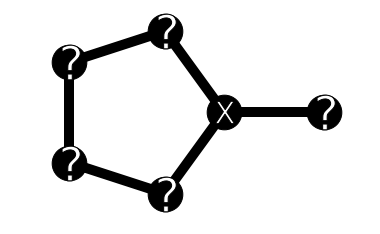

[CH3]
0 1 SINGLE
1 2 SINGLE
2 3 SINGLE
3 4 SINGLE
4 5 SINGLE
5 1 SINGLE

1 <type 'int'>
True
Has kinetics Arrhenius(A=(6.93444e-08,'cm^3/(mol*s)'), n=5.66782, Ea=(47.4142,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.79243, dn = +|- 0.0765887, dEa = +|- 0.421315 kJ/mol""")

1 <type 'int'>
True
Has kinetics Arrhenius(A=(0.000114769,'cm^3/(mol*s)'), n=4.64655, Ea=(63.0782,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.63081, dn = +|- 0.0641873, dEa = +|- 0.353094 kJ/mol""")

0 <type 'int'>
False
failed

1 <type 'int'>
True
Has kinetics Arrhenius(A=(6.4568e-05,'cm^3/(mol*s)'), n=4.64, Ea=(61.3787,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.75077, dn = +|- 0.0735021, dEa = +|- 0.404335 kJ/mol""")

1 <type 'int'>
True
Has kinetics Arrhenius(A=(6.4568e-05,'cm^3/(mol*s)'), n=4.64, Ea=(61.3787,'kJ/mol'), T0=(1,'K

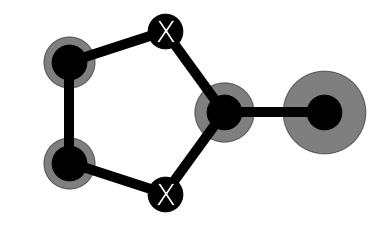

[O]O
0 1 SINGLE
1 2 SINGLE
2 3 SINGLE
3 4 SINGLE
4 5 SINGLE
5 1 SINGLE

1 <type 'int'>
True
Has kinetics Arrhenius(A=(6.50084e-05,'cm^3/(mol*s)'), n=4.6716, Ea=(-4.5502,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.02371, dn = +|- 0.00307558, dEa = +|- 0.0169188 kJ/mol""")

1 <type 'int'>
True
Has kinetics Arrhenius(A=(0.000351729,'cm^3/(mol*s)'), n=4.0713, Ea=(0.934439,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.21002, dn = +|- 0.0250188, dEa = +|- 0.137629 kJ/mol""")

1 <type 'int'>
True
Has kinetics Arrhenius(A=(0.000312729,'cm^3/(mol*s)'), n=4.13191, Ea=(2.00662,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.25162, dn = +|- 0.0294561, dEa = +|- 0.162038 kJ/mol""")

1 <type 'int'>
True
Has kinetics Arrhenius(A=(0.000601848,'cm^3/(mol*s)'), n=4.0819, Ea=(1.37941,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'),

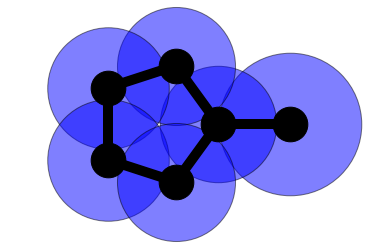

[H]
0 1 SINGLE
1 2 SINGLE
2 3 SINGLE
3 4 SINGLE
4 5 SINGLE
5 1 SINGLE

1 <type 'int'>
True
Has kinetics Arrhenius(A=(0.126947,'cm^3/(mol*s)'), n=4.10394, Ea=(34.1844,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.2523, dn = +|- 0.0295272, dEa = +|- 0.162429 kJ/mol""")

1 <type 'int'>
True
Has kinetics Arrhenius(A=(211.539,'cm^3/(mol*s)'), n=2.8133, Ea=(48.9495,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.03942, dn = +|- 0.00507363, dEa = +|- 0.02791 kJ/mol""")

1 <type 'int'>
True
Has kinetics Arrhenius(A=(214.839,'cm^3/(mol*s)'), n=2.91847, Ea=(48.33,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.12881, dn = +|- 0.015902, dEa = +|- 0.0874768 kJ/mol""")

1 <type 'int'>
True
Has kinetics Arrhenius(A=(323.975,'cm^3/(mol*s)'), n=2.83973, Ea=(47.2527,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), co

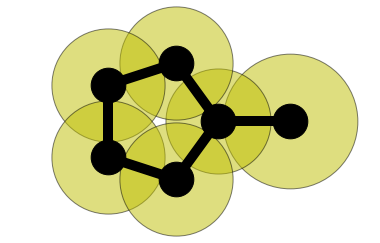

[OH]
0 1 SINGLE
1 2 SINGLE
2 3 SINGLE
3 4 SINGLE
4 5 SINGLE
5 1 SINGLE

1 <type 'int'>
True
Has kinetics Arrhenius(A=(0.0611608,'cm^3/(mol*s)'), n=3.9457, Ea=(64.702,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.25254, dn = +|- 0.0295516, dEa = +|- 0.162564 kJ/mol""")

0 <type 'int'>
False
failed

nan <type 'float'>
False

nan <type 'float'>
False

nan <type 'float'>
False

nan <type 'float'>
False


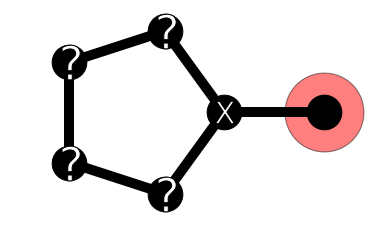

[O][O]
0 1 SINGLE
1 2 SINGLE
2 3 SINGLE
3 4 SINGLE
4 5 SINGLE
5 1 SINGLE


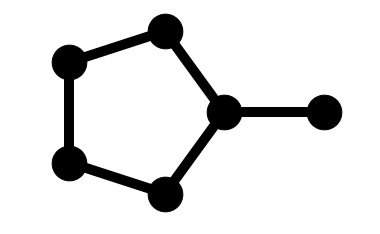

In [10]:
# this is for all molecule of a specifc abstractor 


parent = "CC1CCCC1"
for abstractor in list_of_abstractors:
    print abstractor
    try:
        parent_rdmol = rdkit.Chem.AllChem.MolFromSmiles(parent)
        parent_rdmol.Compute2DCoords()
        tup = parent_rdmol.GetConformers()
        rdconformer = tup[0]
        radical_rdmol = parent_rdmol.__copy__()
        
        fig, ax = plt.subplots(figsize=(6,6), dpi=120)

        # Plotting the atoms of the molecule
        for atom in parent_rdmol.GetAtoms():
            atom_index = atom.GetIdx()

            if atom.GetAtomicNum() == 6:
                plt.scatter(rdconformer.GetAtomPosition(atom_index).x, rdconformer.GetAtomPosition(atom_index).y, c="k", alpha=1, zorder=0)
            elif atom.GetAtomicNum() == 7:
                plt.scatter(rdconformer.GetAtomPosition(atom_index).x, rdconformer.GetAtomPosition(atom_index).y, c="b", alpha=1, zorder=0)
            elif atom.GetAtomicNum() == 8:
                plt.scatter(rdconformer.GetAtomPosition(atom_index).x, rdconformer.GetAtomPosition(atom_index).y, c="r", alpha=1, zorder=0)


        # Plotting the bonds of the molecule
        ax.set_aspect('equal')
        lim = ax.get_xlim()
        lim2 = ax.get_ylim()
        
        if lim > lim2:
            lim = lim2
        diff = abs(lim[0] - lim[1])
        size = 6000 / (diff)
        thick = 50./ (diff)
        
        for atom in parent_rdmol.GetAtoms():
            atom_index = atom.GetIdx()
        
            if atom.GetAtomicNum() == 6:
                plt.scatter(rdconformer.GetAtomPosition(atom_index).x, rdconformer.GetAtomPosition(atom_index).y, c="k", s=size, alpha=1, zorder=10)
            elif atom.GetAtomicNum() == 7:
                plt.scatter(rdconformer.GetAtomPosition(atom_index).x, rdconformer.GetAtomPosition(atom_index).y, c="b", s=size, alpha=1, zorder=10)
            elif atom.GetAtomicNum() == 8:
                plt.scatter(rdconformer.GetAtomPosition(atom_index).x, rdconformer.GetAtomPosition(atom_index).y, c="r", s=size, alpha=1, zorder=10)

        for bond in parent_rdmol.GetBonds():
            print bond.GetBeginAtomIdx(), bond.GetEndAtomIdx(), bond.GetBondType()
            if str(bond.GetBondType()) == "SINGLE" or str(bond.GetBondType()) == "AROMATIC" :
                new_x = [
                    rdconformer.GetAtomPosition(bond.GetBeginAtomIdx()).x,
                    rdconformer.GetAtomPosition(bond.GetEndAtomIdx()).x
                ]
                new_y = [
                    rdconformer.GetAtomPosition(bond.GetBeginAtomIdx()).y,
                    rdconformer.GetAtomPosition(bond.GetEndAtomIdx()).y
                ]

                plt.plot(new_x, new_y, "k", alpha=1,zorder=1, linewidth=thick)

            elif str(bond.GetBondType()) == "DOUBLE":
                rise = rdconformer.GetAtomPosition(bond.GetBeginAtomIdx()).y - rdconformer.GetAtomPosition(bond.GetEndAtomIdx()).y
                run = rdconformer.GetAtomPosition(bond.GetBeginAtomIdx()).x - rdconformer.GetAtomPosition(bond.GetEndAtomIdx()).x


                del_y = sympy.Symbol('del_y')
                try:
                    a = sympy.solvers.solve(0.1**2 - (- (rise/run) * del_y)**2 - del_y**2, del_y)
                    del_x = - (rise/run) * a[0]
                    v_1 = 0.15 * del_x / (del_x**2 + a[0]**2)**0.5
                    v_2 = 0.15 * a[0] / (del_x**2 + a[0]**2)**0.5
                except ZeroDivisionError:
                    v_1 = 0.15
                    v_2 = 0

                new_x = [
                    rdconformer.GetAtomPosition(bond.GetBeginAtomIdx()).x + v_1, 
                    rdconformer.GetAtomPosition(bond.GetEndAtomIdx()).x + v_1
                ]
                new_y = [
                    rdconformer.GetAtomPosition(bond.GetBeginAtomIdx()).y + v_2, 
                    rdconformer.GetAtomPosition(bond.GetEndAtomIdx()).y + v_2
                ]

                newnew_x = [
                    rdconformer.GetAtomPosition(bond.GetBeginAtomIdx()).x - v_1, 
                    rdconformer.GetAtomPosition(bond.GetEndAtomIdx()).x - v_1
                ]
                newnew_y = [
                    rdconformer.GetAtomPosition(bond.GetBeginAtomIdx()).y - v_2, 
                    rdconformer.GetAtomPosition(bond.GetEndAtomIdx()).y - v_2
                ]

                plt.plot(new_x, new_y, "k", alpha=1, zorder=1, linewidth=thick)
                plt.plot(newnew_x, newnew_y, "k", alpha=1, zorder=1, linewidth=thick)

            elif str(bond.GetBondType()) == "TRIPLE":

                rise = rdconformer.GetAtomPosition(bond.GetBeginAtomIdx()).y - rdconformer.GetAtomPosition(bond.GetEndAtomIdx()).y
                run = rdconformer.GetAtomPosition(bond.GetBeginAtomIdx()).x - rdconformer.GetAtomPosition(bond.GetEndAtomIdx()).x



                del_y = sympy.Symbol('del_y')
                a = sympy.solvers.solve(0.1**2 - (- (rise/run) * del_y)**2 - del_y**2, del_y)
                del_x = - (rise/run) * a[0]
                dell_x = - (rise/run) * a[1]
                v_1 = 0.19 * del_x / (del_x**2 + a[0]**2)**0.5
                v_2 = 0.19 * a[0] / (del_x**2 + a[0]**2)**0.5

                new_x = [
                    rdconformer.GetAtomPosition(bond.GetBeginAtomIdx()).x,
                    rdconformer.GetAtomPosition(bond.GetEndAtomIdx()).x
                ]
                new_y = [
                    rdconformer.GetAtomPosition(bond.GetBeginAtomIdx()).y,
                    rdconformer.GetAtomPosition(bond.GetEndAtomIdx()).y
                ]

                newnew_x = [
                    rdconformer.GetAtomPosition(bond.GetBeginAtomIdx()).x + v_1, 
                    rdconformer.GetAtomPosition(bond.GetEndAtomIdx()).x + v_1
                ]
                newnew_y = [
                    rdconformer.GetAtomPosition(bond.GetBeginAtomIdx()).y + v_2, 
                    rdconformer.GetAtomPosition(bond.GetEndAtomIdx()).y + v_2
                ]

                newnewnew_x = [
                    rdconformer.GetAtomPosition(bond.GetBeginAtomIdx()).x - v_1, 
                    rdconformer.GetAtomPosition(bond.GetEndAtomIdx()).x - v_1
                ]
                newnewnew_y = [
                    rdconformer.GetAtomPosition(bond.GetBeginAtomIdx()).y - v_2, 
                    rdconformer.GetAtomPosition(bond.GetEndAtomIdx()).y - v_2
                ]

                plt.plot(new_x, new_y, "k", alpha=1, zorder=1, linewidth=thick)
                plt.plot(newnew_x, newnew_y, "k", alpha=1, zorder=1, linewidth=thick)
                plt.plot(newnewnew_x, newnewnew_y, "k", alpha=1, zorder=1, linewidth=thick)

        for atom in parent_rdmol.GetAtoms():
            if atom.GetNumImplicitHs() != 0:
                atom_index = atom.GetIdx()

                radical_rdmol = parent_rdmol.__copy__()

                radical_rdmol.GetAtomWithIdx(atom_index).SetNumRadicalElectrons(1)
                radical_smiles = rdkit.Chem.AllChem.MolToSmiles(radical_rdmol)

                has_kinetics = df[((df["Abstractor"] == abstractor) & (df["Radical Molecule"] == radical_smiles))].loc[parent]["Has Kinetics"]
                kinetics = df[((df["Abstractor"] == abstractor) & (df["Radical Molecule"] == radical_smiles))].loc[parent]["Arrhenius Expression"]

                #Plotting a ? if there is no kinetics
                print 
                print has_kinetics, type(has_kinetics)
                print has_kinetics == 1
                if not has_kinetics > -1:
                    plt.scatter(rdconformer.GetAtomPosition(atom_index).x, rdconformer.GetAtomPosition(atom_index).y, c="w", s=size, alpha=1, zorder=10, marker="$?$")
                    #plt.show()
                elif has_kinetics == float(0):
                    print "failed"
                    plt.scatter(rdconformer.GetAtomPosition(atom_index).x, rdconformer.GetAtomPosition(atom_index).y, marker="$X$", s=500, c="w", zorder=10000)
                    #plt.show()
                elif has_kinetics == float(1):
                    print "Has kinetics", kinetics
                    color = color_dict[abstractor]
                    rate = np.log10(kinetics.getRateCoefficient(T=1000, P=1e5))*500*thick 
                    
                    plt.scatter(rdconformer.GetAtomPosition(atom_index).x, rdconformer.GetAtomPosition(atom_index).y, s=rate, alpha=0.50, zorder=0, c=color, clip_on=False)
        
        #lim = ax.get_xlim()
        #lim2 = ax.get_ylim()
        #ax.set_xlim(lim*2)
        #ax.set_ylim(lim2*2)
        plt.axis("off")
        plt.show()
        fig.savefig("/gss_gpfs_scratch/harms.n/plots" + parent +"_"+ abstractor+".pdf")
                    
    except:
        plt.axis("off")
        #plt.show()
        pass

In [11]:
df.loc[parent], radical_smiles

(                Abstractor                               Arrhenius Expression  \
 Parent Molecule                                                                 
 CC1CCCC1              [O]O  Arrhenius(A=(0.000351729,'cm^3/(mol*s)'), n=4....   
 CC1CCCC1              [O]O  Arrhenius(A=(0.000312729,'cm^3/(mol*s)'), n=4....   
 CC1CCCC1              [O]O  Arrhenius(A=(0.000601848,'cm^3/(mol*s)'), n=4....   
 CC1CCCC1              [O]O  Arrhenius(A=(6.50084e-05,'cm^3/(mol*s)'), n=4....   
 CC1CCCC1              [OH]                                                NaN   
 CC1CCCC1              [OH]                                                NaN   
 CC1CCCC1              [OH]                                                NaN   
 CC1CCCC1              [OH]  Arrhenius(A=(0.0611608,'cm^3/(mol*s)'), n=3.94...   
 CC1CCCC1               [H]  Arrhenius(A=(211.539,'cm^3/(mol*s)'), n=2.8133...   
 CC1CCCC1               [H]  Arrhenius(A=(214.839,'cm^3/(mol*s)'), n=2.9184...   
 CC1CCCC1       

In [12]:
df[(df["Radical Molecule"] == radical_smiles)]

,Abstractor,Arrhenius Expression,Has Kinetics,Log Number,Parent Molecule,Radical Molecule,Reaction
Parent Molecule,,,,,,,
CC1CCCC1,[O]O,"Arrhenius(A=(6.50084e-05,'cm^3/(mol*s)'), n=4....",1,48,CC1CCCC1,[CH2]C1CCCC1,"<Molecule ""OO""> + <Molecule ""[CH2]C1CCCC1""> <=..."
CC1CCCC1,[OH],"Arrhenius(A=(0.0611608,'cm^3/(mol*s)'), n=3.94...",1,188,CC1CCCC1,[CH2]C1CCCC1,"<Molecule ""O""> + <Molecule ""[CH2]C1CCCC1""> <=>..."
CC1CCCC1,[H],"Arrhenius(A=(0.126947,'cm^3/(mol*s)'), n=4.103...",1,325,CC1CCCC1,[CH2]C1CCCC1,"<Molecule ""[H][H]""> + <Molecule ""[CH2]C1CCCC1""..."
CC1CCCC1,[O],NaN,NaN,461,CC1CCCC1,[CH2]C1CCCC1,"<Molecule ""[O]""> + <Molecule ""CC1CCCC1""> <=> <..."
CC1CCCC1,[CH3],"Arrhenius(A=(6.93444e-08,'cm^3/(mol*s)'), n=5....",1,598,CC1CCCC1,[CH2]C1CCCC1,"<Molecule ""C""> + <Molecule ""[CH2]C1CCCC1""> <=>..."


## Looking at a random molecule and trying to make the plotting feature work

0 1 SINGLE
1 2 SINGLE
2 3 SINGLE
3 4 SINGLE
4 5 SINGLE
1 6 SINGLE
6 7 SINGLE
7 8 SINGLE
8 9 SINGLE


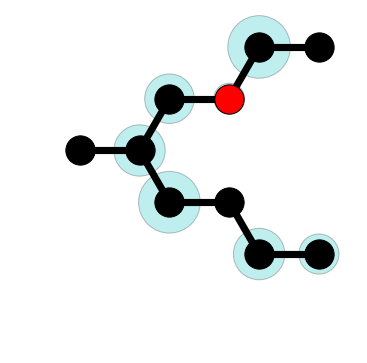

In [13]:

smiles = "CC(COCC)CCCC"
try:
    rdmol = rdkit.Chem.AllChem.MolFromSmiles(smiles)
except:
    rdmol = rdkit.Chem.AllChem.MolFromInchi(smiles)
rdmol.Compute2DCoords()
tup = rdmol.GetConformers()
rdconformer = tup[0]
rates = np.random.rand(rdconformer.GetNumAtoms())*4000 #figure out how to get rates
#for atom in rdmol.Atoms:
#igure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
fig, ax = plt.subplots(figsize=(6,6), dpi=120)

x=[]
y=[]


for i in range(rdconformer.GetNumAtoms()):
    indx = rdmol.GetAtomWithIdx(i).GetIdx()
    #print rdmol.GetAtoms()[i].GetAtomicNum()
    #print rdconformer.GetAtomPosition(i).x, rdconformer.GetAtomPosition(i).y, rdconformer.GetAtomPosition(i).z
    x.append(rdconformer.GetAtomPosition(indx).x)
    y.append(rdconformer.GetAtomPosition(indx).y)
    
ax.scatter(x,y, s=rates, c='c', alpha=0.25, zorder=0)
    
ax.set_aspect('equal')
lim = ax.get_xlim()
lim2 = ax.get_ylim()
if lim > lim2:
    lim = lim2
diff = abs(lim[0] - lim[1])
size = 12000 / (2*diff)
thick = 50./ ( diff)

minimum = np.min((ax.get_xlim(),ax.get_ylim()))
maximum = np.max((ax.get_xlim(),ax.get_ylim()))
    
    # ToDo: Fix for double, triple bonds

ax.set_xlim(minimum*1.2,maximum*1.2)
ax.set_ylim(minimum*1.2,maximum*1.2)


for bond in rdmol.GetBonds():
    print bond.GetBeginAtomIdx(), bond.GetEndAtomIdx(), bond.GetBondType()
    if str(bond.GetBondType()) == "SINGLE":
        new_x = [x[bond.GetBeginAtomIdx()], x[bond.GetEndAtomIdx()]]
        new_y = [y[bond.GetBeginAtomIdx()], y[bond.GetEndAtomIdx()]]
        plt.plot(new_x, new_y, "k", alpha=1,zorder=1, linewidth=thick)
    elif str(bond.GetBondType()) == "DOUBLE":
        rise = y[bond.GetBeginAtomIdx()] - y[bond.GetEndAtomIdx()]
        run = x[bond.GetBeginAtomIdx()] - x[bond.GetEndAtomIdx()]
        

        del_y = sympy.Symbol('del_y')
        try:
            a = sympy.solvers.solve(0.1**2 - (- (rise/run) * del_y)**2 - del_y**2, del_y)
            del_x = - (rise/run) * a[0]
            v_1 = 0.15 * del_x / (del_x**2 + a[0]**2)**0.5
            v_2 = 0.15 * a[0] / (del_x**2 + a[0]**2)**0.5
        except ZeroDivisionError:
            v_1 = 0.15
            v_2 = 0
            
        
    
        
        new_x = [x[bond.GetBeginAtomIdx()] + v_1, x[bond.GetEndAtomIdx()] + v_1]
        new_y = [y[bond.GetBeginAtomIdx()] + v_2, y[bond.GetEndAtomIdx()] + v_2]
        newnew_x = [x[bond.GetBeginAtomIdx()] - v_1, x[bond.GetEndAtomIdx()] - v_1]
        newnew_y = [y[bond.GetBeginAtomIdx()] - v_2, y[bond.GetEndAtomIdx()] - v_2]
        plt.plot(new_x, new_y, "k", alpha=1, zorder=1, linewidth=thick)
        plt.plot(newnew_x, newnew_y, "k", alpha=1, zorder=1, linewidth=thick)
    elif str(bond.GetBondType()) == "TRIPLE":
        
        rise = y[bond.GetBeginAtomIdx()] - y[bond.GetEndAtomIdx()]
        run = x[bond.GetBeginAtomIdx()] - x[bond.GetEndAtomIdx()]
        

        del_y = sympy.Symbol('del_y')
        a = sympy.solvers.solve(0.1**2 - (- (rise/run) * del_y)**2 - del_y**2, del_y)
        del_x = - (rise/run) * a[0]
        dell_x = - (rise/run) * a[1]
        v_1 = 0.24 * del_x / (del_x**2 + a[0]**2)**0.5
        v_2 = 0.24 * a[0] / (del_x**2 + a[0]**2)**0.5
        
        new_x = [x[bond.GetBeginAtomIdx()], x[bond.GetEndAtomIdx()]]
        new_y = [y[bond.GetBeginAtomIdx()], y[bond.GetEndAtomIdx()]]
        newnew_x = [x[bond.GetBeginAtomIdx()] + v_1, x[bond.GetEndAtomIdx()] + v_1]
        newnew_y = [y[bond.GetBeginAtomIdx()] + v_2, y[bond.GetEndAtomIdx()] + v_2]
        newnewnew_x = [x[bond.GetBeginAtomIdx()] - v_1, x[bond.GetEndAtomIdx()] - v_1]
        newnewnew_y = [y[bond.GetBeginAtomIdx()] - v_2, y[bond.GetEndAtomIdx()] - v_2]
        plt.plot(new_x, new_y, "k", alpha=1, zorder=1, linewidth=thick)
        plt.plot(newnew_x, newnew_y, "k", alpha=1, zorder=1, linewidth=thick)
        plt.plot(newnewnew_x, newnewnew_y, "k", alpha=1, zorder=1, linewidth=thick)
        
    
    


plt.axis("off")


for i in range(rdconformer.GetNumAtoms()):
    indx = rdmol.GetAtomWithIdx(i).GetIdx()
    if rdmol.GetAtoms()[i].GetAtomicNum() == 6:
        plt.scatter(rdconformer.GetAtomPosition(indx).x, rdconformer.GetAtomPosition(indx).y, c="k", s=size, alpha=1, zorder=10)
    elif rdmol.GetAtoms()[i].GetAtomicNum() == 7:
        plt.scatter(rdconformer.GetAtomPosition(indx).x, rdconformer.GetAtomPosition(indx).y, c="b", s=size, alpha=1, zorder=10)
    elif rdmol.GetAtoms()[i].GetAtomicNum() == 8:
        plt.scatter(rdconformer.GetAtomPosition(indx).x, rdconformer.GetAtomPosition(indx).y, c="r", s=size, alpha=1, zorder=10)


